# jobflow

## Define workflow with jobflow

This tutorial will demonstrate how to use the PWD with `jobflow` and load the workflow with `aiida` and `pyiron`.

[`jobflow`](https://joss.theoj.org/papers/10.21105/joss.05995) was developed to simplify the development of high-throughput workflows. It uses a decorator-based approach to define the “Job“s that can be connected to form complex workflows (“Flow“s). `jobflow` is the workflow language of the workflow library [`atomate2`](https://chemrxiv.org/engage/chemrxiv/article-details/678e76a16dde43c9085c75e9), designed to replace [atomate](https://www.sciencedirect.com/science/article/pii/S0927025617303919), which was central to the development of the [Materials Project](https://pubs.aip.org/aip/apm/article/1/1/011002/119685/Commentary-The-Materials-Project-A-materials) database.

First, we start by importing the job decorator and the Flow class from jobflow, as welll as the necessary modules from the python workflow definition and the example arithmetic workflow.

In [1]:
from jobflow import job, Flow

In [2]:
from python_workflow_definition.jobflow import write_workflow_json

In [3]:
from workflow import (
    get_sum as _get_sum,
    get_prod_and_div as _get_prod_and_div,
    get_square as _get_square,
)

Using the job object decorator, the imported functions from the arithmetic workflow are transformed into jobflow “Job”s. These “Job”s can delay the execution of Python functions and can be chained into workflows (“Flow”s). A “Job” can return serializable outputs (e.g., a number, a dictionary, or a Pydantic model) or a so-called “Response” object, which enables the execution of dynamic workflows where the number of nodes is not known prior to the workflow’s execution. 

In [4]:
workflow_json_filename = "jobflow_simple.json"

In [5]:
get_sum = job(_get_sum)
# Note: one could also transfer the outputs to the datastore as well: get_prod_and_div = job(_get_prod_and_div, data=["prod", "div"])
# On the way from the general definition to the jobflow definition, we do this automatically to avoid overflow databases.
get_prod_and_div = job(_get_prod_and_div)
get_square = job(_get_square)

In [6]:
prod_and_div = get_prod_and_div(x=1, y=2)

In [7]:
tmp_sum = get_sum(x=prod_and_div.output.prod, y=prod_and_div.output.div)

In [8]:
result = get_square(x=tmp_sum.output)

In [9]:
flow = Flow([prod_and_div, tmp_sum, result])

As jobflow itself is only a workflow language, the workflows are typically executed on high-performance computers with a workflow manager such as [Fireworks](https://onlinelibrary.wiley.com/doi/full/10.1002/cpe.3505) or [jobflow-remote](https://github.com/Matgenix/jobflow-remote). For smaller and test workflows, simple linear, non-parallel execution of the workflow graph can be performed with jobflow itself. All outputs of individual jobs are saved in a database. For high-throughput applications typically, a MongoDB database is used. For testing and smaller workflows, a memory database can be used instead.

In [10]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [11]:
!cat {workflow_json_filename}

{
  "version": "0.1.0",
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.get_prod_and_div"
    },
    {
      "id": 1,
      "type": "function",
      "value": "workflow.get_sum"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.get_square"
    },
    {
      "id": 3,
      "type": "input",
      "name": "x",
      "value": 1
    },
    {
      "id": 4,
      "type": "input",
      "name": "y",
      "value": 2
    },
    {
      "id": 5,
      "type": "output",
      "name": "result"
    }
  ],
  "edges": [
    {
      "target": 0,
      "targetPort": "x",
      "source": 3,
      "sourcePort": null
    },
    {
      "target": 0,
      "targetPort": "y",
      "source": 4,
      "sourcePort": null
    },
    {
      "target": 1,
      "targetPort": "x",
      "source": 0,
      "sourcePort": "prod"
    },
    {
      "target": 1,
      "targetPort": "y",
      "source": 0,
      "sourcePort": "div"
    },
    {
      "t

Finally, you can write the workflow data into a JSON file to be imported later.

## Load Workflow with aiida

In this part, we will demonstrate how to import the `jobflow` workflow into `aiida` via the PWD.

In [12]:
from aiida import load_profile

load_profile()

Profile<uuid='3ce302a995914d2e8a7b6327a10fe381' name='pwd'>

In [13]:
from python_workflow_definition.aiida import load_workflow_json

We import the necessary modules from `aiida` and the PWD, as well as the workflow JSON file.

In [14]:
wg = load_workflow_json(file_name=workflow_json_filename)
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

Finally, we are now able to run the workflow with `aiida`.

In [15]:
wg.run()

05/24/2025 05:38:40 AM <306> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_prod_and_div1
05/24/2025 05:38:41 AM <306> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|update_task_state]: Task: get_prod_and_div1, type: PyFunction, finished.
05/24/2025 05:38:41 AM <306> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_sum2
05/24/2025 05:38:41 AM <306> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|update_task_state]: Task: get_sum2, type: PyFunction, finished.
05/24/2025 05:38:41 AM <306> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_square3
05/24/2025 05:38:42 AM <306> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|update_task

## Load Workflow with pyiron_base

In this part, we will demonstrate how to import the `jobflow` workflow into `pyiron` via the PWD.

In [16]:
from python_workflow_definition.pyiron_base import load_workflow_json

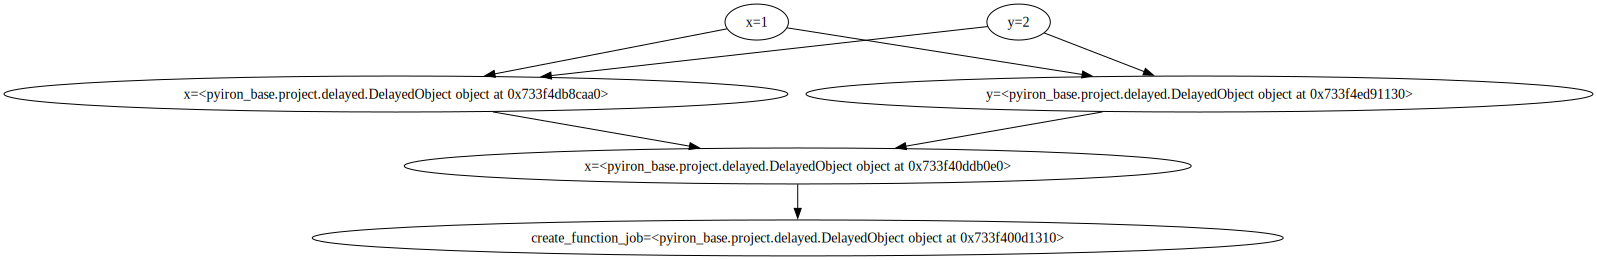

In [17]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [18]:
delayed_object_lst[-1].pull()

The job get_prod_and_div_00cf2c787390eacfbc4a51e9a0c38ec7 was saved and received the ID: 1
The job get_sum_4b5b9d16b259a13b6a32798ce2779af8 was saved and received the ID: 2
The job get_square_9cc2f0545498916d7720c59c1120a66d was saved and received the ID: 3


6.25

Here, the procedure is the same as before: Import the necessary `pyiron_base` module from the PWD, import the workflow JSON file and run the workflow with pyiron.

## Load Workflow with pyiron_workflow

In [ ]:
from python_workflow_definition.pyiron_workflow import load_workflow_json

In [ ]:
wf = load_workflow_json(file_name=workflow_json_filename)

In [ ]:
wf.draw(size=(10,10))

In [ ]:
wf.run()